In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K  
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

2024-03-31 06:16:24.706351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 06:16:24.706446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 06:16:24.849211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:


def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "img/*")))
    masks = sorted(glob(os.path.join(path, "mask/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [3]:

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model():
    size = 256
    #num_filters = [32, 64, 128, 256 , 512]
    num_filters = [64,128, 256, 512 , 1024]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs
    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()
    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)


if __name__ == "__main__":
    model = build_model()
    model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 78,608,897 (299.87 MB)

 Trainable params: 78,588,929 (299.79 MB)

 Non-trainable params: 19,968 (78.00 KB)

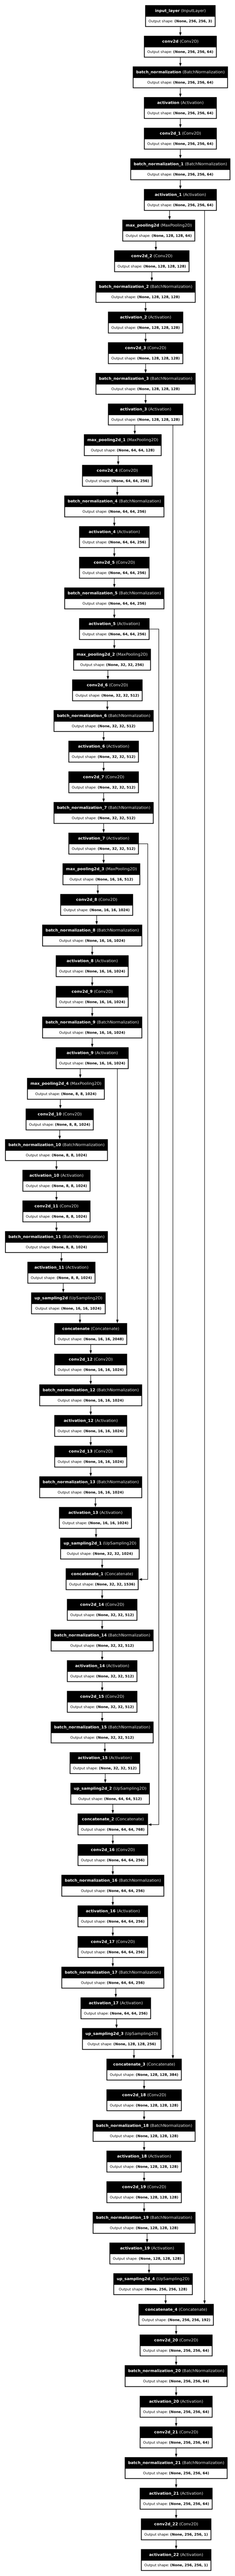

In [4]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_architecture.png')
plt.figure(figsize=(40, 80))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [5]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float64))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float64))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

if __name__ == "__main__":

    batch = 16
    lr = 3e-4
    epochs = 100
    path = '/kaggle/input/data-img-mask/img_mask'
    
    (train_x, train_y) , (valid_x, valid_y), (test_x, test_y) = load_data(path)

    train_dataset = tf_dataset(train_x, train_y, batch=batch)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

    model = build_model()

    opt = tf.keras.optimizers.Adam(lr)
    metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), dice_coef]
    model.compile(loss=dice_coef_loss, optimizer=opt, metrics=metrics)

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint("model.keras", save_best_only=True)
    ]

    train_steps = len(train_x)//batch
    valid_steps = len(valid_x)//batch

    if len(train_x) % batch != 0:
        train_steps += 1
    if len(valid_x) % batch != 0:
        valid_steps += 1
        

    
    history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=epochs,
                    steps_per_epoch=train_steps,
                    validation_steps=valid_steps,
                    callbacks=callbacks)
    model.save("final_model.keras")


Epoch 1/100


2024-03-31 06:17:14.856350: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.11841, expected 2.65729
2024-03-31 06:17:14.856639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27392: 3.3488, expected 2.88768
2024-03-31 06:17:14.856781: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38656: 3.55356, expected 3.09244
2024-03-31 06:17:14.857020: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.62512, expected 2.96419
2024-03-31 06:17:14.857059: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 4.47177, expected 3.81084
2024-03-31 06:17:14.857077: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 5.40808, expected 4.74715
2024-03-31 06:17:14.857090: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 5.33073, expected 4.66979
2024-03-31 06:17:14.857103: E ex

103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - acc: 0.7552 - dice_coef: 0.7081 - loss: 0.2919 - precision: 0.6700 - recall: 0.8092

2024-03-31 06:19:21.285764: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.61827, expected 2.62157
2024-03-31 06:19:21.285825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.51962, expected 4.52292
2024-03-31 06:19:21.285834: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.53584, expected 4.53914
2024-03-31 06:19:21.285842: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.94599, expected 5.94929
2024-03-31 06:19:21.285850: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 7.73571, expected 6.73901
2024-03-31 06:19:21.285858: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.13476, expected 6.13806
2024-03-31 06:19:21.285865: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.95982, expected 5.96312
2024-03-31 06:19:21.285873: E external/local_xla/xla/se

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - acc: 0.7555 - dice_coef: 0.7085 - loss: 0.2915 - precision: 0.6704 - recall: 0.8095

2024-03-31 06:20:14.695705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.55785, expected 1.95285
2024-03-31 06:20:14.695755: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.63579, expected 2.03079
2024-03-31 06:20:14.695770: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.40614, expected 2.80114
2024-03-31 06:20:14.695788: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.61062, expected 3.00562
2024-03-31 06:20:14.695800: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.23405, expected 2.62905
2024-03-31 06:20:14.695810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.10193, expected 3.49693
2024-03-31 06:20:14.695821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.09802, expected 3.49302
2024-03-31 06:20:14.695831: E external/local_xla/xla/se

104/104 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - acc: 0.7559 - dice_coef: 0.7090 - loss: 0.2910 - precision: 0.6709 - recall: 0.8097 - val_acc: 0.7003 - val_dice_coef: 0.6289 - val_loss: 0.3711 - val_precision: 0.5906 - val_recall: 0.8010 - learning_rate: 3.0000e-04
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 48s 466ms/step - acc: 0.8357 - dice_coef: 0.8037 - loss: 0.1963 - precision: 0.7760 - recall: 0.8561 - val_acc: 0.6182 - val_dice_coef: 0.0322 - val_loss: 0.9678 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 48s 466ms/step - acc: 0.8523 - dice_coef: 0.8253 - loss: 0.1747 - precision: 0.8015 - recall: 0.8637 - val_acc: 0.7341 - val_dice_coef: 0.5000 - val_loss: 0.5000 - val_precision: 0.9144 - val_recall: 0.3421 - learning_rate: 3.0000e-04
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 508ms/step - acc: 0.8644 - dice_coef: 0.8405 - loss: 0.1595 - precision: 0.8217 - recall: 0.8688 - val_acc: 0.8330 - val_dice_coef: 0

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import load_model
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0 
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

model = load_model("final_model.keras", custom_objects={'dice_coef':dice_coef,'dice_coef_loss': dice_coef_loss})

test_images = [read_image(path) for path in test_x]
test_images = np.array(test_images)

prediction_test = model.predict(test_images, batch_size=8)

true_labels = [read_mask(path) for path in test_y]
true_labels = np.array(true_labels)

binary_predictions = (prediction_test > 0.5).astype(int)
y_test_bool = (true_labels > 0.5).astype(bool)

accuracy_test = accuracy_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))
presision_score_test = precision_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))
recall_score_test = recall_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))
f1_score_test = f1_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))
dice_test = dice_coef(true_labels, binary_predictions).numpy()


print(f'Precision:  {presision_score_test * 100:.2f}%')
print(f'Recall: {recall_score_test * 100:.2f}%')
print(f'accuracy: {accuracy_test * 100:.2f}%')
print(f'Dice Coefficient: {dice_test * 100:.2f}%')
print(f'F1 Score: {f1_score_test * 100:.2f}%')

2024-03-31 06:48:37.265041: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.72144, expected 2.89031
2024-03-31 06:48:37.265101: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.65806, expected 4.82693
2024-03-31 06:48:37.265117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.98376, expected 5.15263
2024-03-31 06:48:37.265135: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.6283, expected 5.79717
2024-03-31 06:48:37.265148: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.90088, expected 6.06975
2024-03-31 06:48:37.265159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.70007, expected 5.86894
2024-03-31 06:48:37.265170: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.75339, expected 4.92226
2024-03-31 06:48:37.265180: E external/local_xla/xla/ser

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

2024-03-31 06:48:56.342595: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.13039, expected 2.54847
2024-03-31 06:48:56.342653: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.06686, expected 3.48494
2024-03-31 06:48:56.342671: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.75322, expected 4.1713
2024-03-31 06:48:56.342689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.68977, expected 4.10784
2024-03-31 06:48:56.342715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 4.43621, expected 3.85429
2024-03-31 06:48:56.342725: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 4.29776, expected 3.71584
2024-03-31 06:48:56.342735: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 4.58573, expected 4.00381
2024-03-31 06:48:56.342745: E external/local_xla/xla/s

26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 578ms/step
Precision:  90.55%
Recall: 91.36%
accuracy: 92.84%
Dice Coefficient: 90.94%
F1 Score: 90.95%


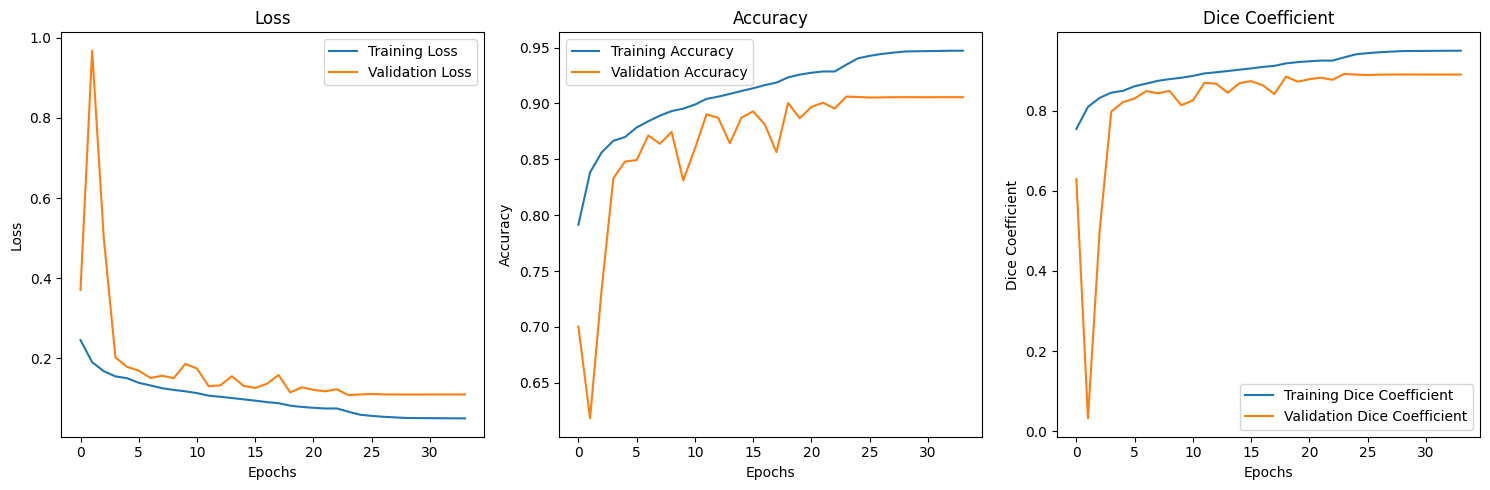

In [7]:
# Vẽ biểu đồ Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Vẽ biểu đồ Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ biểu đồ Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


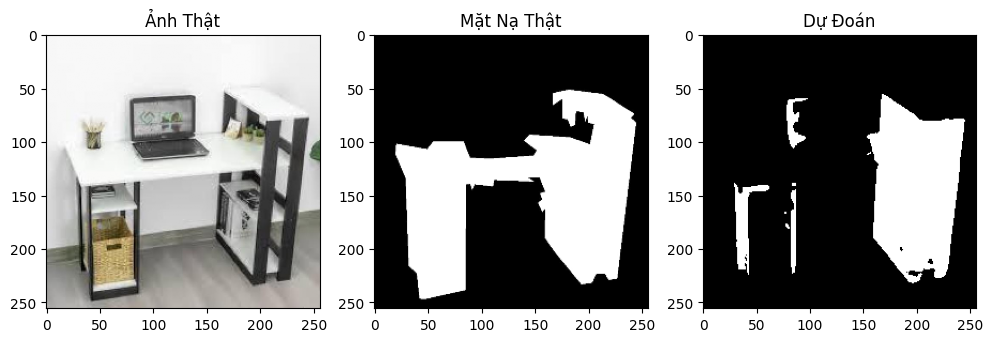

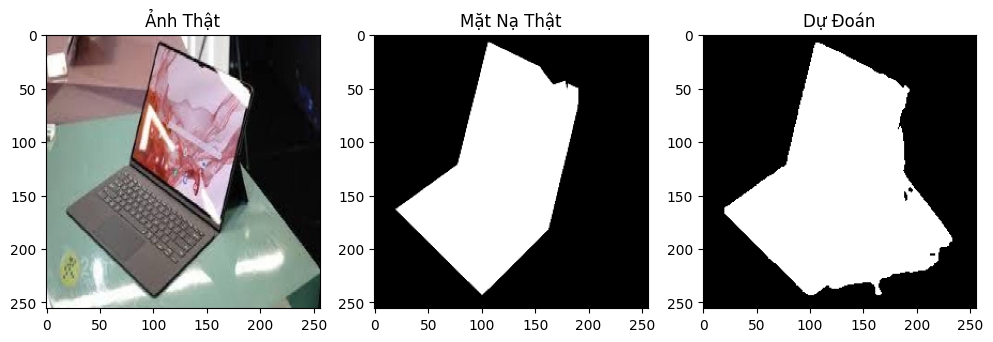

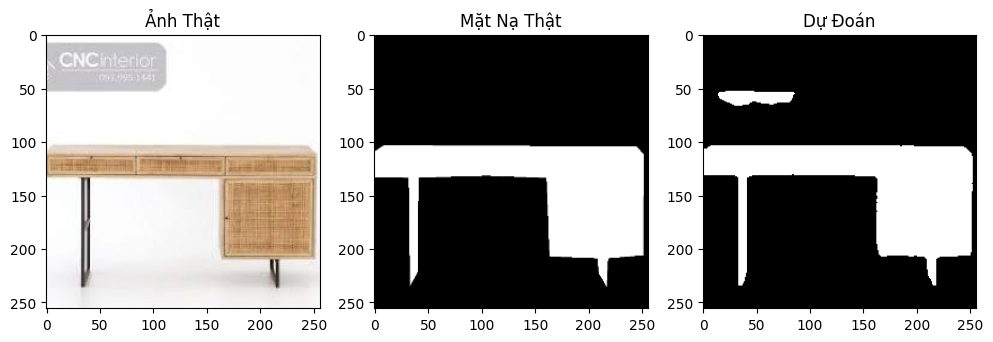

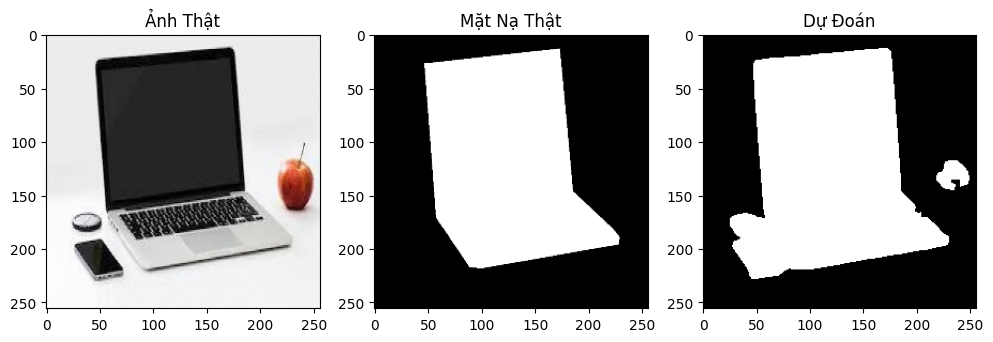

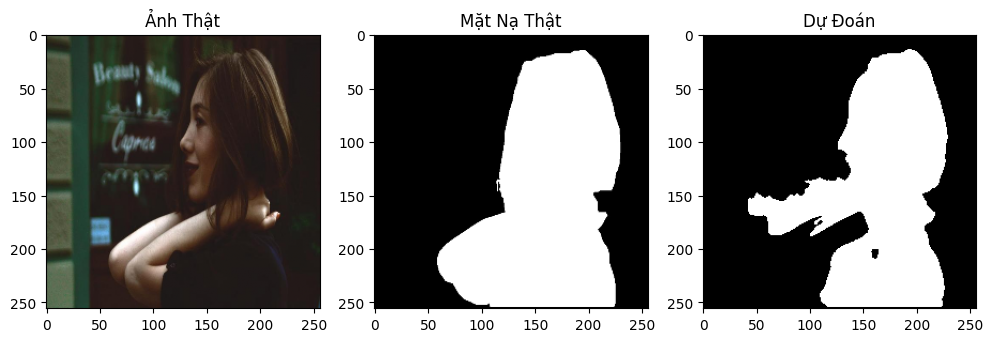

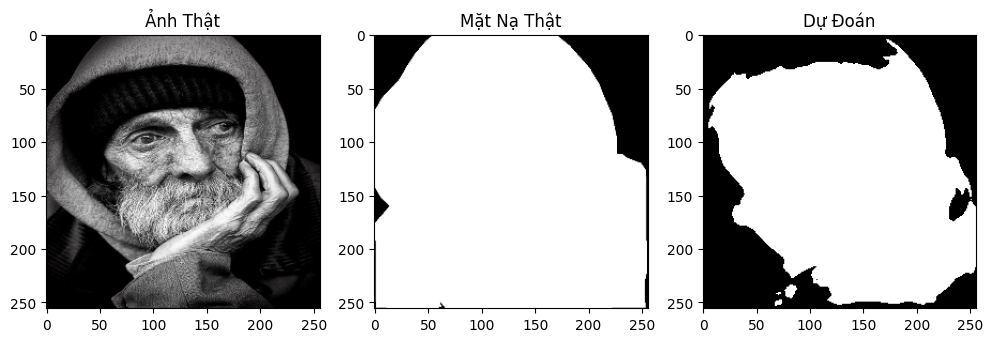

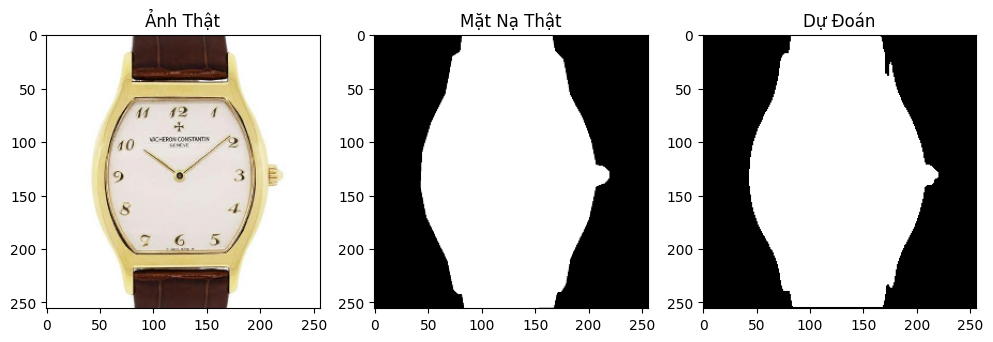

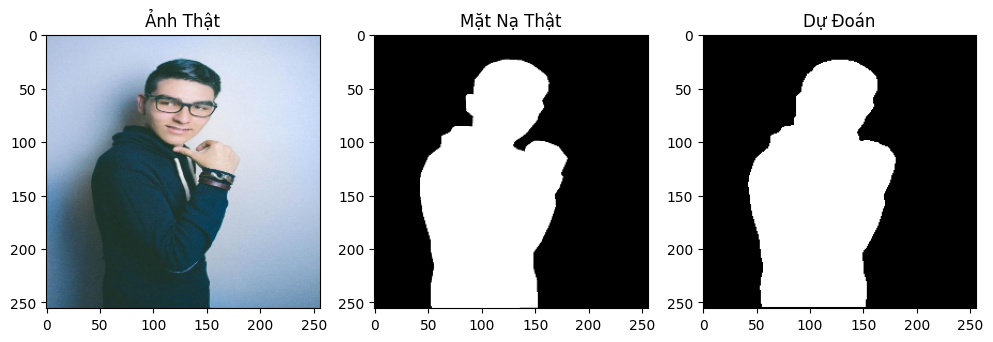

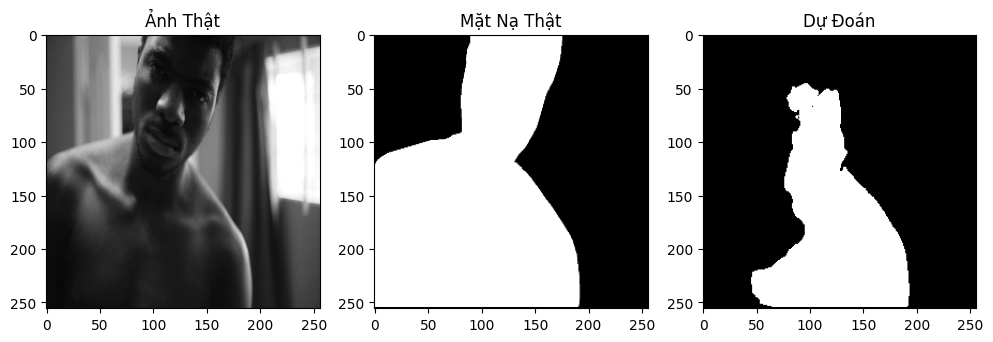

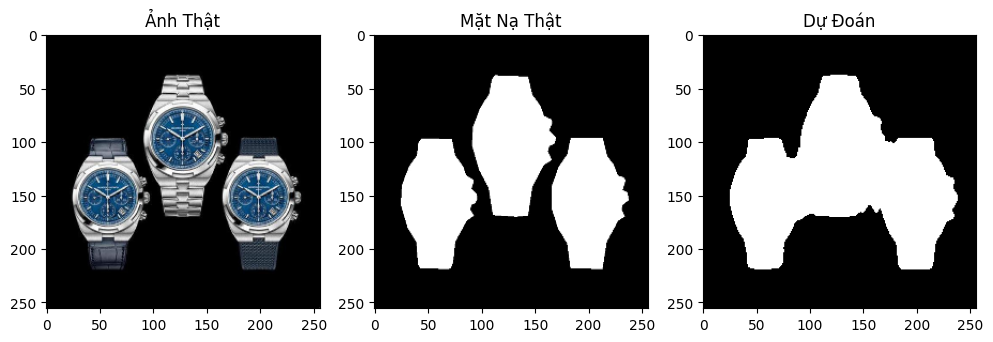

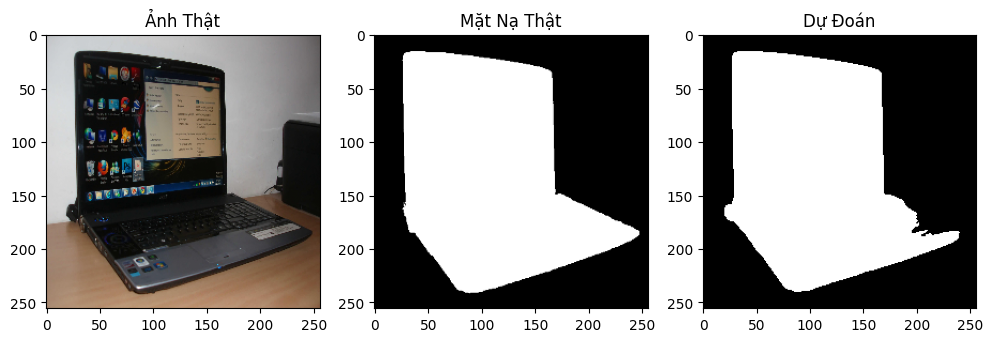

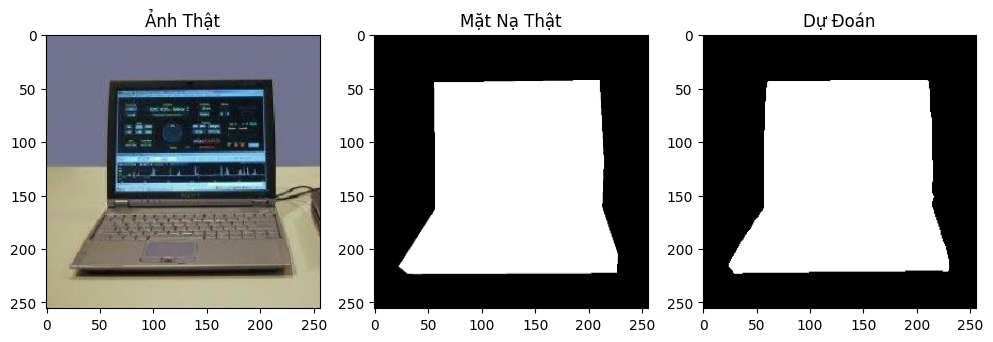

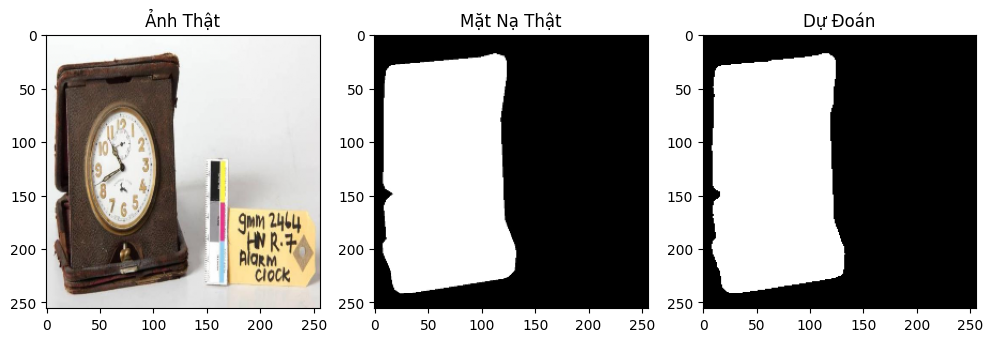

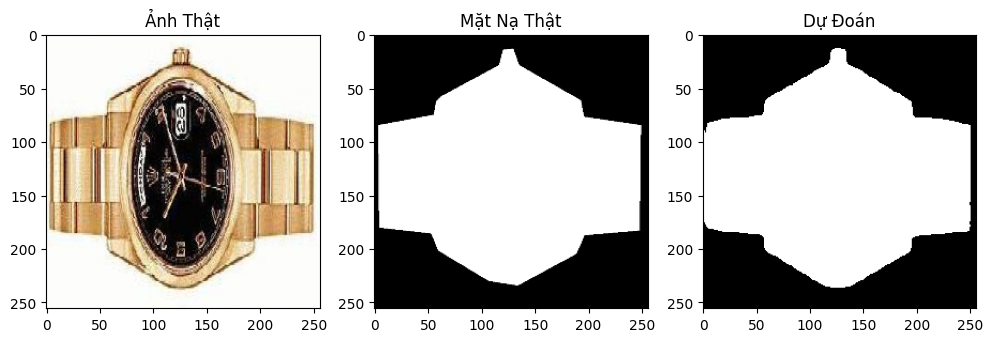

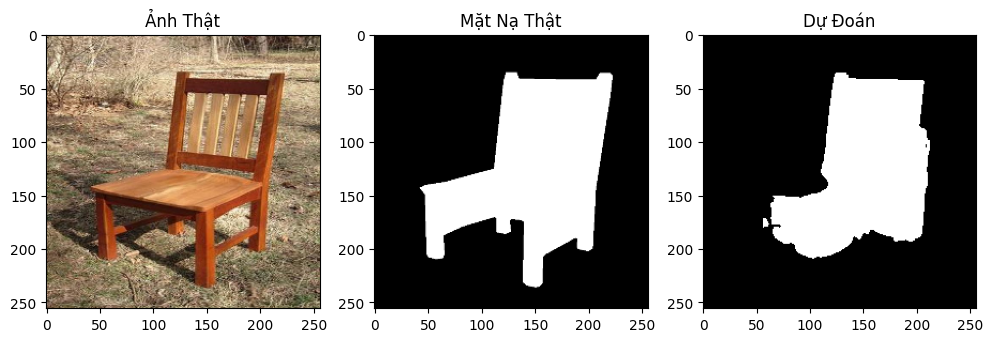

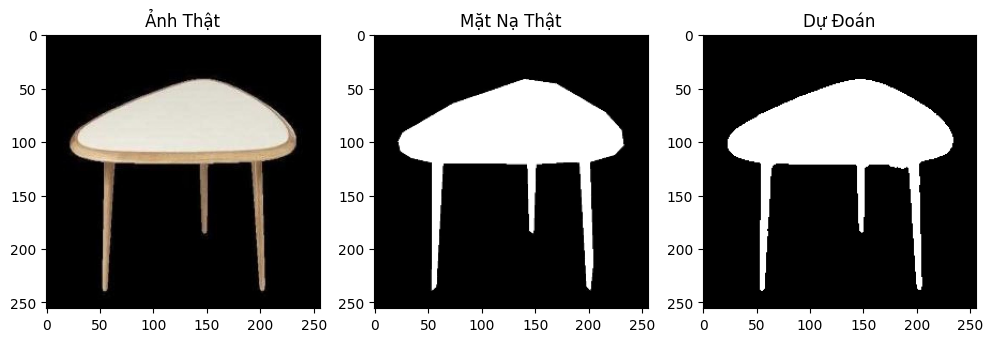

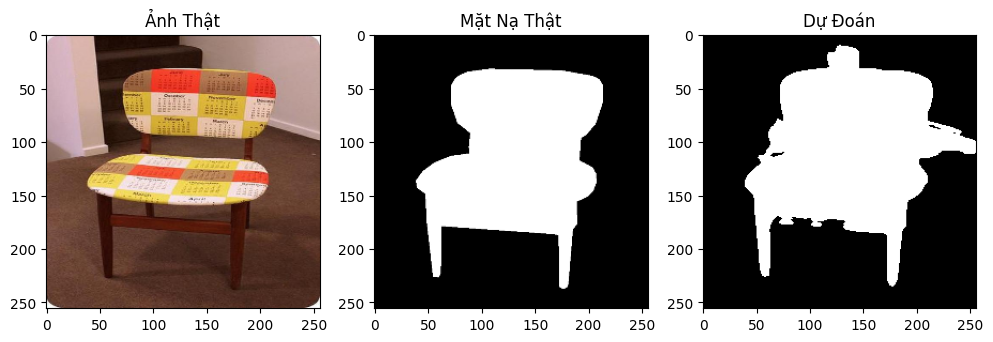

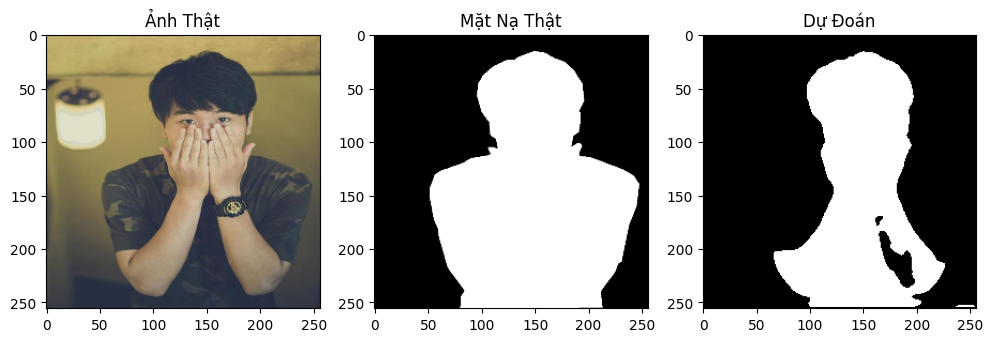

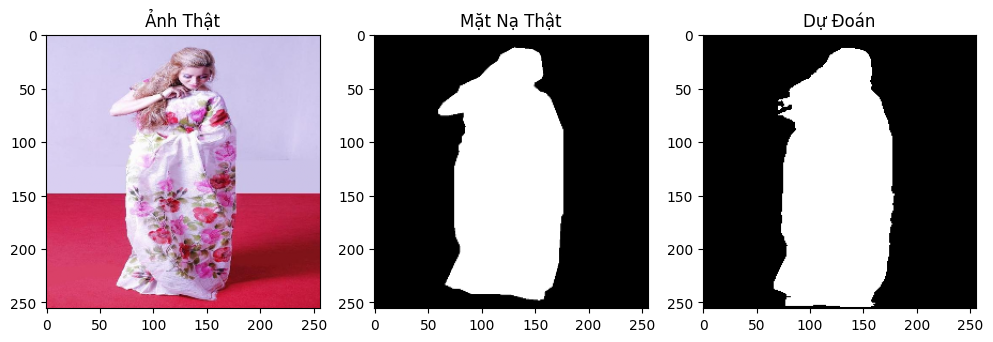

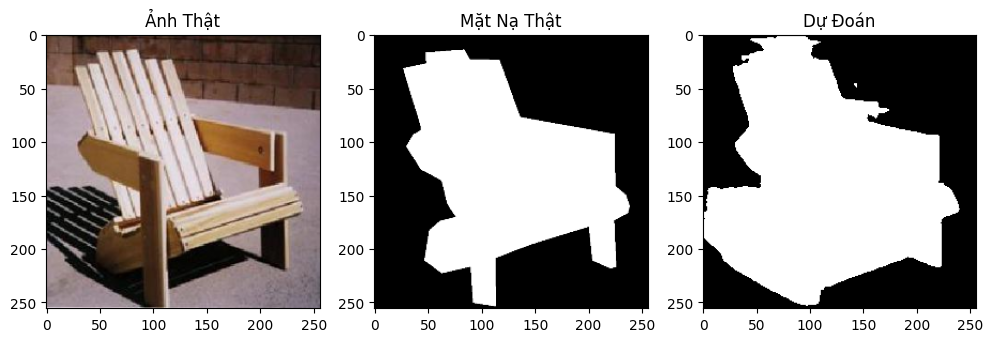

In [8]:

first_10_images = test_images[:20]
first_10_true_labels = true_labels[:20]
first_10_predictions = binary_predictions[:20]

for i in range(20):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(first_10_images[i][...,::-1])
    plt.title('Ảnh Thật')

    plt.subplot(1, 3, 2)
    plt.imshow(first_10_true_labels[i], cmap='gray')
    plt.title('Mặt Nạ Thật')

    plt.subplot(1, 3, 3)
    plt.imshow(first_10_predictions[i], cmap='gray')
    plt.title('Dự Đoán')

    plt.show()